# Stochastic Variance Reduction Methods for Policy Evaluation

## Convex Optimization: Project

### Team Members:

- Gautham Bellamkonda
- Pranav Khalsanka Nayak


# Problem Statement

Consider the minimization of objective in equation (7) in https://proceedings.mlr.press/v70/du17a/du17a.pdf. Find a dual of min (7) by eliminating $\theta$ from equation (10). Highlight the formula for computing the primal solution using the dual solution. Since the primal and dual are unconstrained quadratics, one can solve them using accelerated gradient descent. Note that the per iteration cost is $O(nd^2)$ (assume $n\ge d$) for both primal and dual algos. We already know for reaching $\epsilon$ optimal solution we need $\log(\frac{1}{\epsilon})$ iterations. The paper proposes to solve something "in-between" the primal and dual (saddle-point form), which is equation (10). This problem has both primal and dual variables. The idea is to perform block coordinate (gradient based) descent\&ascent  on primal\&dual variables. The algorithm is in equation (12). The advantage is computing (12) requires only $O(nd)$. Interestingly, in theorem~1, they show this algorithm  also has linear convergence i.e., for reaching $\epsilon$ optimal solution we need $\log(\frac{1}{\epsilon})$ iterations. Thus primal and dual algorithms shall be worse than the proposed primal-dual algorithm.


### a

Derive a dual of min (7) by eliminating $\theta$ from equation (10). Highlight the formula for computing the primal solution using the dual solution.

Equation (7) describes the minimization objective:

$$
\text{MSPBE}(\theta) = \frac{1}{2} \| \hat A \theta - \hat b \|^2_{\hat C^{-1}} + \frac{\rho}{2} \| \theta \|^2
$$

To minimize this objective with respect to $\theta$, we introduce the dual variable $w$ and write the Lagrangian as:

$$
\mathcal{L}(\theta, w) = \frac{\rho}{2} \| \theta \|^2 - w^T \hat A \theta - (\frac{1}{2} w^T \hat C w - w^T \hat b)
$$

<!-- Minimizing MSPBE with respect to $\theta$ is equivalent to solving  -->

<!-- $$ -->
<!-- % \min_{\theta} \max_{w} \mathcal{L}(\theta, w) -->
<!-- % $$ -->

Taking the gradient of $\mathcal{L}(\theta, w)$ with respect to $\theta$ and setting it to zero, we get:

\begin{align*}
\rho \theta - \hat A^T w &= 0\\
\theta &= \frac{\hat A^T w}{\rho}
\end{align*}

Substituting this back into the Lagrangian, we get the dual objective:

\begin{align*}
\max_{w} g(w) &= \max_{w} -\frac{1}{2 \rho} w^T \hat A \hat A^T w - (\frac{1}{2} w^T \hat C w - w^T \hat b)\\
&= \max_{w} -\frac{1}{2 \rho} w^T \hat A \hat A^T w - \frac{1}{2} w^T \hat C w + w^T \hat b\\
&= \max_{w} -\frac{1}{2 \rho} w^T (\hat A \hat A^T + \rho \hat C) w + w^T \hat b\\
&= \min_{w} \frac{1}{2 \rho} w^T (\hat A \hat A^T + \rho \hat C) w - w^T \hat b
\end{align*}

The primal solution can be computed using the dual solution as:

$$
\theta^* = \frac{\hat A^T w^*}{\rho}
$$


In [1]:
# code accelerated gradient descent for the primal problem

import numpy as np
import matplotlib.pyplot as plt
import time


In [2]:
# MDP with 400 states and 10 actions. 

NUM_STATES = 400
NUM_ACTIONS = 10
GAMMA = 0.95

# states are represented by 201 dimensional vectors, where the first 200 dimensions are sampled from U[0, 1]
# the last dimension is 1
states = np.random.rand(NUM_STATES, 200)
states = np.concatenate((states, np.ones((NUM_STATES, 1))), axis=1)

# transition probabilities are sampled from U[0, 1]

transition_prob = np.random.rand(NUM_STATES, NUM_ACTIONS, NUM_STATES) + 1e-5
transition_prob = transition_prob / np.sum(transition_prob, axis=2, keepdims=True)

# policy is sampled from U[0, 1]
policy = np.random.rand(NUM_STATES, NUM_ACTIONS) + 1e-5
policy = policy / np.sum(policy, axis=1, keepdims=True)

# start distribution is sampled from U[0, 1]
start_distribution = np.random.rand(NUM_STATES) + 1e-5
start_distribution = start_distribution / np.sum(start_distribution)

# reward function is sampled from U[0, 1]
reward = np.random.rand(NUM_STATES, NUM_ACTIONS) + 1e-5

# sample transitions for T = 20_000
T = 20_000
A = np.zeros((201, 201))
b = np.zeros(201)
C = np.zeros((201, 201))

state = np.random.choice(NUM_STATES, p=start_distribution)
for t in range(T):
    action = np.random.choice(NUM_ACTIONS, p=policy[state])
    next_state = np.random.choice(NUM_STATES, p=transition_prob[state, action])
    r = reward[state, action]
    A += np.outer(states[state], states[state] - GAMMA * states[next_state])
    b += r * states[state]
    C += np.outer(states[state], states[state])
    state = next_state

A /= T
b /= T
C /= T

In [3]:
n = 201

rho = 0.1

hessian = A.T @ np.linalg.pinv(C) @ A + rho * np.eye(n)
eigvals = np.linalg.eigvals(hessian)
L = np.max(eigvals)

dual_hessian = (A @ A.T)/rho + C
dual_eigvals = np.linalg.eigvals(dual_hessian)
L_dual = np.max(dual_eigvals)

mu = 1/L_dual
mu_dual = 1/L

def reg(theta):
    return 0.5*rho*l2norm(theta)**2

def l2norm(theta):
    return np.linalg.norm(theta)

def l1norm(theta):
    return np.linalg.norm(theta, 1)

def infty_norm(theta):
    return np.linalg.norm(theta, np.inf)

def primal_objective(theta):
    return 0.5*((A @ theta - b).T @ np.linalg.pinv(C) @ (A @ theta - b) + rho*np.linalg.norm(theta)**2)
    # return  rho*np.linalg.norm(theta)**2

def primal_gradient(theta):
    return A.T @ np.linalg.pinv(C) @ (A @ theta - b) + rho * theta
    # return rho * theta

def dual_objective(w):
    return 1/(2*rho) *  w.T @ (A@A.T + rho*C) @ w - w.T @ b

def dual_gradient(w):
    return 1/rho * (A@A.T + rho*C) @ w - b



def accelerated_gradient_descent(objective, gradient, L, epsilon):
    y_prev = y = x = np.zeros(n)
    objective_values = []
    i = 0
    kappa = 1.5
    l = 1
    l_prev = 0
    while True:
        y = x - 1/L * gradient(x)

        # smooth + strong convexity (primal)
        # x = (1 + (np.sqrt(kappa)-1)/(np.sqrt(kappa) + 1)) * y - (np.sqrt(kappa) -1)/(np.sqrt(kappa) + 1) * y_prev
        
        # smooth only (dual)
        gamma = (1-l_prev)/l
        x = (1 - gamma) * y + gamma * y_prev
        l_prev = l
        l = 0.5 * (1 + np.sqrt(1 + 4*l**2))
        
        # ??? some other type of acceleration
        # x = y + (_-1)/(_+2) * (y - y_prev)

        y_prev = y
        objective_values.append(objective(x))
        print(i, objective(x))
        i+=1
        if i>2 and np.abs(objective_values[-1] - np.min(objective_values[:-1])) < epsilon:  # check for convergence
            break

    # plot the objective value
    plt.plot(objective_values)
    plt.show()
    return objective_values

In [4]:
# # make a 3d plot of the objective function
# # primal objective takes a vector of shape (2,1)

# def plot_objective():
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     x = np.linspace(-10, 10, 100)
#     y = np.linspace(-10, 10, 100)
#     X, Y = np.meshgrid(x, y)
#     Z = np.zeros((100, 100))
#     for i in range(x.shape[0]):
#         for j in range(y.shape[0]):
#             Z[i,j] = primal_objective(np.array([x[i], y[j]]))
#     ax.plot_surface(X, Y, Z)
#     plt.show()

# plot_objective()
    

0 0.12913557460514763
1 0.0790418952574545
2 0.07503168495970541
3 0.07431988365314521
4 0.0742212199625363
5 0.0742148196107994
6 0.07421231313145894
7 0.07420788600812406
8 0.07420453903159124
9 0.07420306451772285
10 0.07420271688462768
11 0.07420270068289685
12 0.07420267499192151
13 0.07420261196394305
14 0.07420255928200092
15 0.07420253522416674
16 0.07420252967525769
17 0.0742025291696914


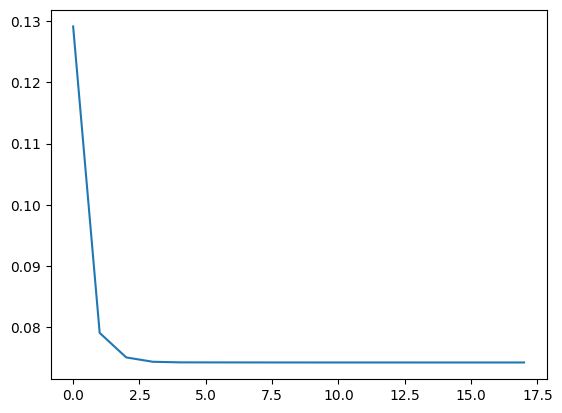

Time taken to run accelerated gradient descent:  0.722550630569458


In [5]:
start = time.time()
objective_values = accelerated_gradient_descent(primal_objective, primal_gradient, L, 1e-9)
end = time.time()
print("Time taken to run accelerated gradient descent: ", end - start)


0 0.0
1 -0.05325798855420473
2 -0.05329667561179148
3 -0.05334328573821302
4 -0.05339749064411098
5 -0.0534589797407934
6 -0.0535274442430905
7 -0.053602570193766144
8 -0.053684035482993206
9 -0.05377150891100982
10 -0.05386465039635427
11 -0.053963111868029504
12 -0.05406653858144047
13 -0.05417457069942132
14 -0.05428684503448628
15 -0.054402996879916204
16 -0.05452266187642594
17 -0.054645477873462495
18 -0.05477108675256939
19 -0.05489913618632257
20 -0.05502928131100613
21 -0.05516118629498756
22 -0.055294525787985487
23 -0.055428986239288554
24 -0.05556426707559595
25 -0.055700081731571975
26 -0.0558361585284779
27 -0.05597224139837968
28 -0.05610809045343821
29 -0.05624348240166766
30 -0.05637821081229276
31 -0.05651208623544049
32 -0.05664493618235703
33 -0.056776604973641516
34 -0.05690695346412475
35 -0.057035858653991287
36 -0.057163213196541184
37 -0.057288924813614556
38 -0.05741291563015573
39 -0.057535121439678344
40 -0.05765549091251394
41 -0.05777398475868741
42 -0.057

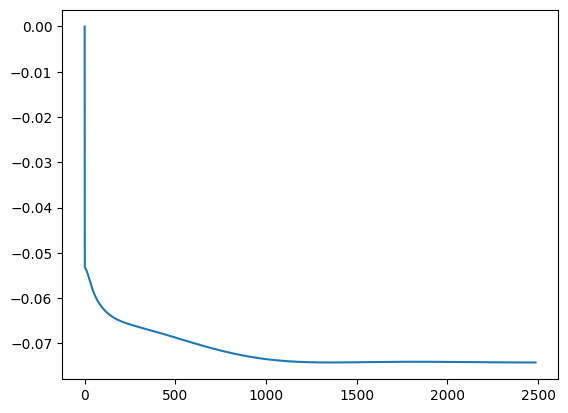

Time taken to run accelerated gradient descent:  3.599876880645752


In [6]:
start = time.time()
objective_values = accelerated_gradient_descent(dual_objective, dual_gradient, L_dual, 1e-9)
end = time.time()
print("Time taken to run accelerated gradient descent: ", end - start)
